In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics.pairwise import haversine_distances
from sklearn.preprocessing import OneHotEncoder
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import  XGBRegressor
from lightgbm import LGBMRegressor

During this project, we'll be trying to create a model capable of predicting the price of an Airbnb stay in NewYork City based on different characteristics such as neighbourhood, room_type, etc. 

This model would prove to be very beneficial for hosts looking to save money and find the most suitable option for accomodation in the city that never sleeps :)

In [146]:
data= pd.read_csv('AB_NYC_2019.csv')
clean_data= data.copy() #copy of original data that we'll edit
clean_data.sort_values('id', ascending=True, inplace=True) 
clean_data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [147]:
clean_data.isnull().sum().sort_values(ascending=False)

last_review                       10052
reviews_per_month                 10052
host_name                            21
name                                 16
neighbourhood_group                   0
neighbourhood                         0
id                                    0
host_id                               0
longitude                             0
latitude                              0
room_type                             0
price                                 0
number_of_reviews                     0
minimum_nights                        0
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In order not to eliminate the data from the 10052 missing values of last_review and reviews_per_month, we can simply replace those with 0! We should note that 0 is not a valid time value, so we'll probably end up with values that are NaT (Not a Time) when we perform the pd.to_datatime. We'll use the date 1970-01-01 for the 'last_review' column instead, which is commonly used to represent the beggining of the Unix Epoch (date and time refered to the starting point for tracking time in computer systems). 

For the missing name and host_name values, since they are very few, we'll simply drop those rows. 

In [148]:
clean_data['last_review']= clean_data['last_review'].fillna('1970-01-01')
clean_data['reviews_per_month']= clean_data['reviews_per_month'].fillna(0)
clean_data.dropna(subset=['name', 'host_name'], inplace=True)
clean_data['last_review']= pd.to_datetime(clean_data['last_review'], errors='coerce')

In [149]:
clean_data.drop('id', axis=1, inplace=True) #id is not useful for analysis and can be dropped
clean_data.drop_duplicates(inplace=True) #remove duplicates
clean_data.reset_index(drop=True, inplace=True) #reset index after dropping duplicates

We'll now start analysing the features values and their distributions, as well as cleaning the data! Starting with the removal of impossible/unlikely values:

In [150]:
clean_data = clean_data[clean_data['minimum_nights'] <= 365]  
clean_data = clean_data[clean_data['availability_365'] <= 365]

Now, on to what we're trying to predict, the price, let's try and make sure it isn't poorly distributed in a way that may affect a future model!

Text(0.5, 1.0, 'Full Price Distribution')

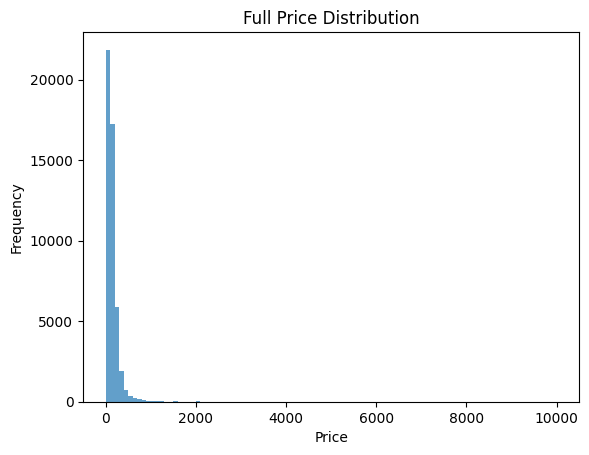

In [151]:
plt.hist(clean_data['price'], bins=100, alpha=0.7)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Full Price Distribution')

In [152]:
zero_prices = (clean_data['price'] == 0).sum()
high_prices = (clean_data['price'] > 1000).sum()
very_high_prices = (clean_data['price'] > 5000).sum()

print(f'Zero prices:{zero_prices}')
print(f'High prices:{high_prices}')
print(f'Very high prices:{very_high_prices}')

Zero prices:11
High prices:239
Very high prices:20


We can see there are some very extreme values that are not according to the majority of the distribution, which we'll remove promptly:

Text(0.5, 1.0, 'Cleaned Data Price Distribution')

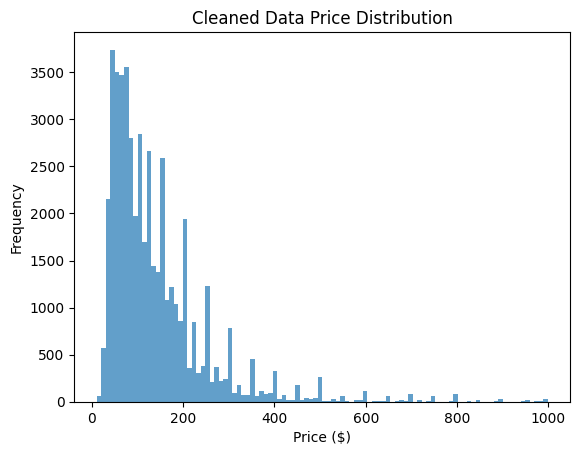

In [153]:
clean_data= clean_data[clean_data['price']>10] #remove extremely low values
clean_data= clean_data[clean_data['price']<1000] #remove extremely high values

plt.hist(clean_data['price'], bins=100, alpha=0.7)
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.title('Cleaned Data Price Distribution')

Text(0, 0.5, 'Number of Listings')

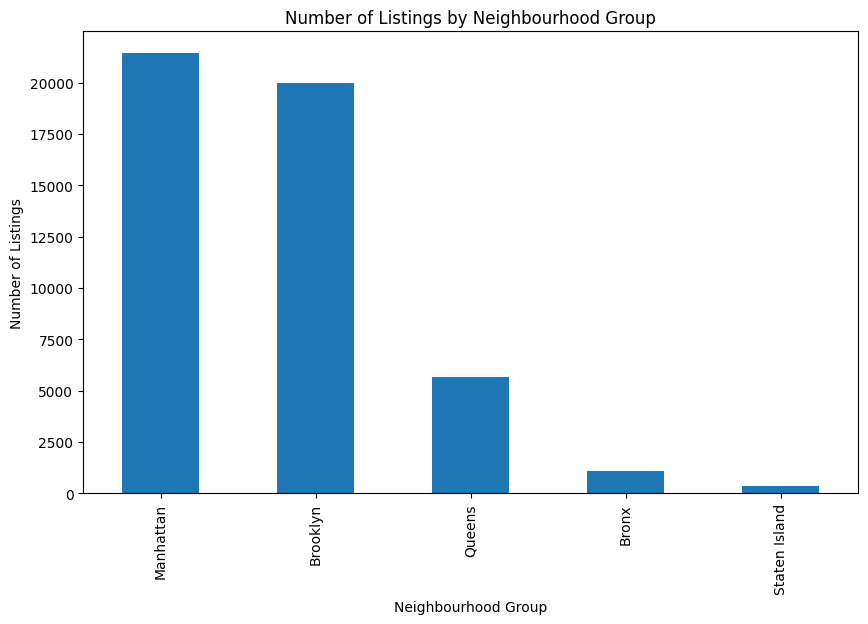

In [154]:
figure = plt.figure(figsize=(10, 6))
ax = figure.add_subplot(111)
clean_data.value_counts('neighbourhood_group').plot(kind='bar', ax=ax)
ax.set_title('Number of Listings by Neighbourhood Group')
ax.set_xlabel('Neighbourhood Group')
ax.set_ylabel('Number of Listings')

There are many more places available in Manhattan and Brooklyn, which may mean that the model may work better for places in those areas.

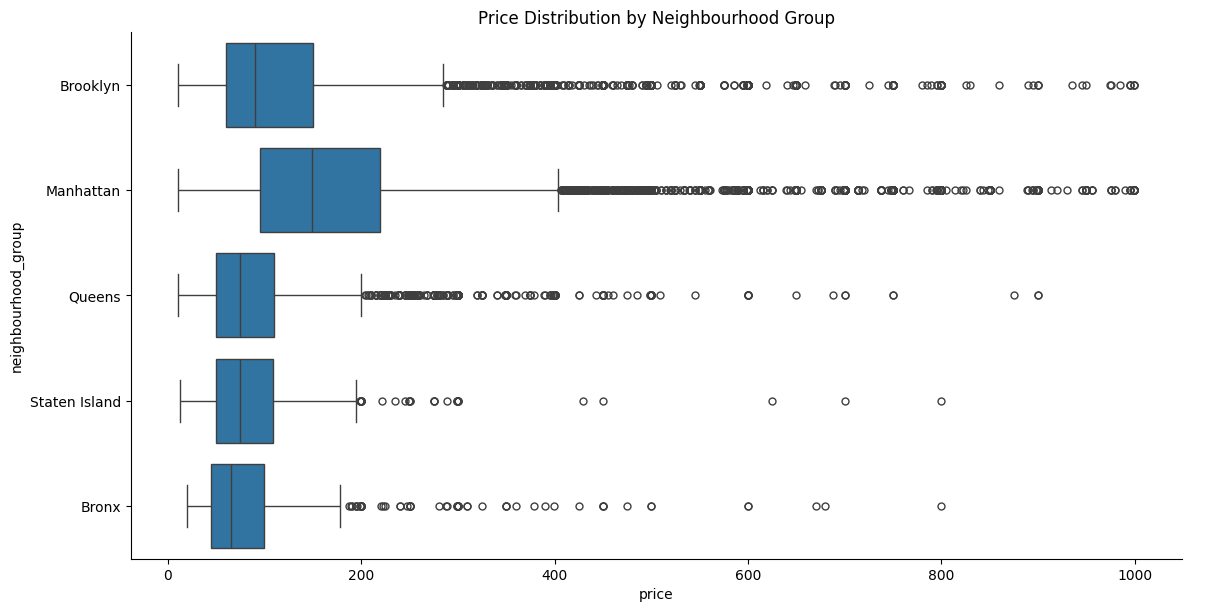

In [155]:
sns.catplot(data=clean_data, x="price", y="neighbourhood_group", kind="box", height=6, aspect=2).set(title='Price Distribution by Neighbourhood Group')

As we can see from the graph above, the mean value of the prices per neighborhood is similar. However, we can tell that some neighborhoods such as Manhattan and Brooklyn have wider inter-quartile width, with Manhattan having a bigger mean value. This translates to a more distribuited price range, particularly towards the high price end.
We can also spot outlier values for Brooklyn, Manhattan and Queens, which can latter affect our predictions and model development. However, since they are singular, and the count of places listed in each of these neighborhoods is significant, they are likely to not have that strong of an effect.

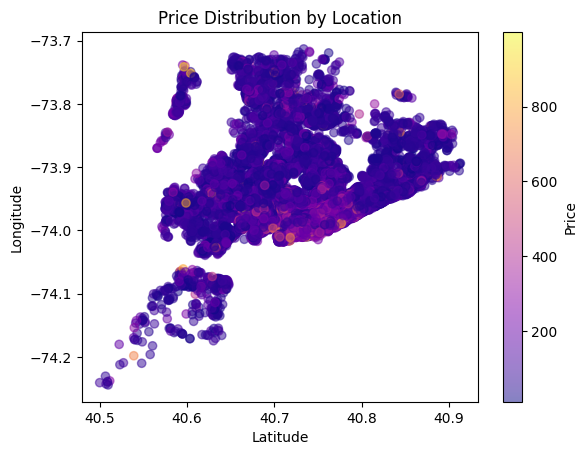

In [156]:
plt.scatter(clean_data['latitude'], clean_data['longitude'], cmap='plasma', c=clean_data['price'], alpha=0.5)
plt.title('Price Distribution by Location')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.colorbar(label='Price')

There seems to be a relation between the location and the price, with some areas being characteristically more expensive!

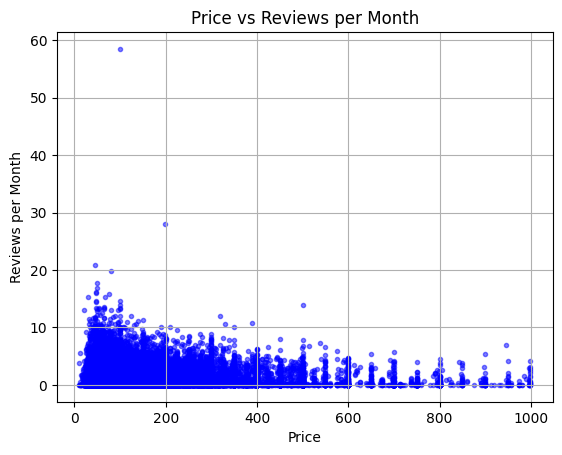

In [157]:
plt.scatter(clean_data['price'], clean_data['reviews_per_month'],alpha=0.5, marker='.', color='blue')
plt.title('Price vs Reviews per Month')
plt.xlabel('Price')
plt.ylabel('Reviews per Month')
plt.grid(True)

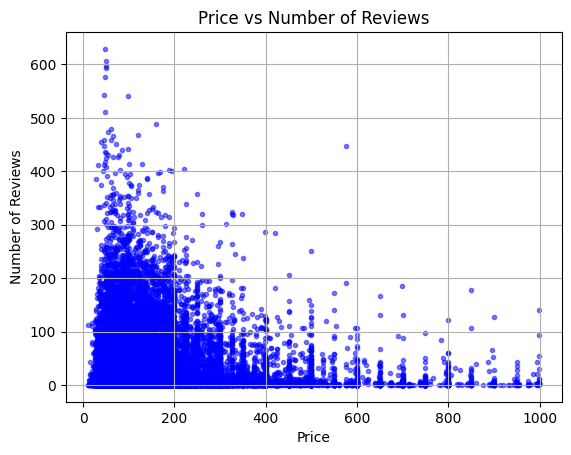

In [158]:
plt.scatter(clean_data['price'], clean_data['number_of_reviews'],alpha=0.5, marker='.', color='blue')
plt.title('Price vs Number of Reviews')
plt.xlabel('Price')
plt.ylabel('Number of Reviews')
plt.grid(True)

It seems that, as the price goes up, the number of reviews is never high, whether we're talking about monthly or the total number of reviews. So, all the places with high number of reviews are on the less expensive end, altough the whole price range is composed of places with low number of reviews.

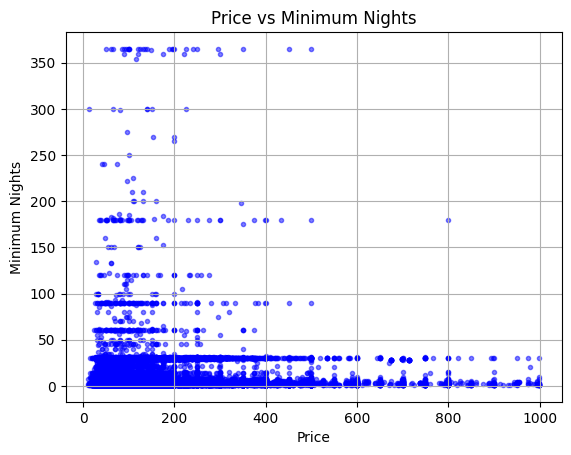

In [159]:
plt.scatter(clean_data['price'], clean_data['minimum_nights'],alpha=0.5, marker='.', color='blue')
plt.title('Price vs Minimum Nights')
plt.xlabel('Price')
plt.ylabel('Minimum Nights')
plt.grid(True)

Again, similar with the review distribution, we may note that places demanding a higher number of minimum nights tend to be cheaper, although in this case we can still spot some places with higher price with a minimum number of nights a bit higher. 

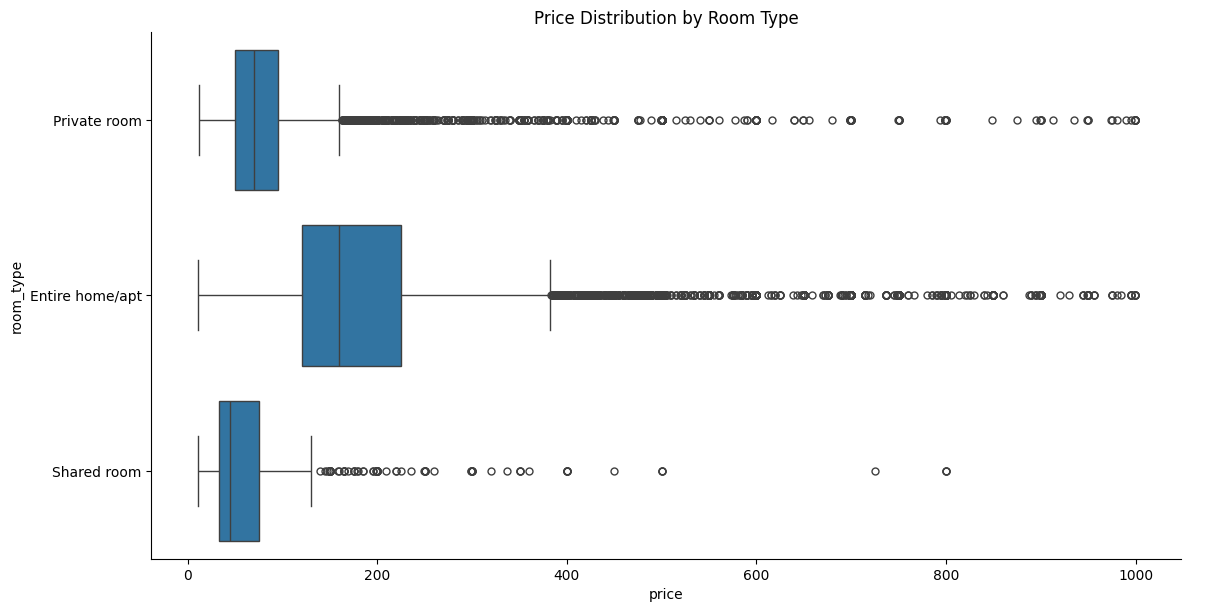

In [160]:
sns.catplot(data=clean_data, x="price", y="room_type", kind="box", height=6, aspect=2).set(title='Price Distribution by Room Type')

We can see that this feature has a very strong relation with the price! Accomodations with shared room tend to be cheaper, with a medium and quartiles smaller than the other types. It is followed by private room accomodations and, last but not least, entire room/apt, which are the most expensive. 

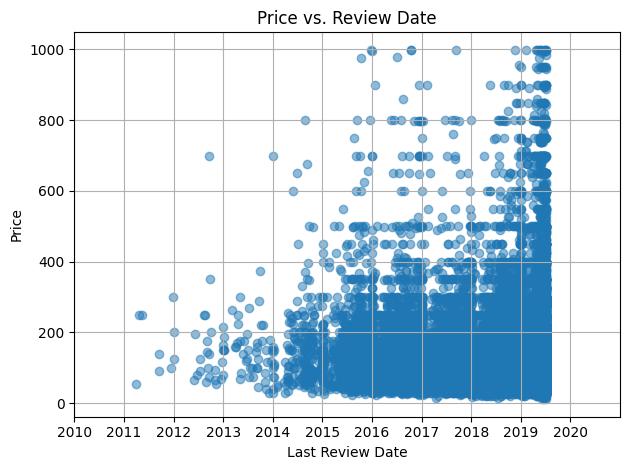

In [161]:
plt.scatter(clean_data['last_review'], clean_data['price'], alpha=0.5)
plt.xlim(np.datetime64('2010-01-01'),
                  np.datetime64('2020-12-31'))
plt.xlabel('Last Review Date')
plt.ylabel('Price')
plt.title('Price vs. Review Date')
plt.grid(True)
plt.tight_layout()
plt.show()

It seems that places listed with higher prices have more recent reviews, although the lower-price range covers accomodations with both recent and older reviews.   

Let's now do some *feature engineering* to gather some more interesting and helpful infomration from our data!

We can start with creating a new column where we'll calculate the distance from each place to, per example, The Statue of Liberty, so we can have a direct comparison tool.

In [162]:
#Statue of Liberty coordinates
statue_of_liberty_coords = [40.689247, -74.044502]

clean_data['distance_to_statue_of_liberty'] = clean_data.apply(
    lambda row: haversine_distances([[np.radians(row['latitude']), np.radians(row['longitude'])]], 
                                    [np.radians(statue_of_liberty_coords)])[0,0]*6371  , axis=1) # multiply by Earth radius to get km

Now we'll create two one-hot encoding, one for the room type and another for the neighbourhood group to have a more clear organization of those features.

In [163]:
categorical_columns = ['room_type', 'neighbourhood_group']
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(clean_data[categorical_columns])
one_hot_encoded_data = pd.DataFrame(
    one_hot_encoded,
    columns=encoder.get_feature_names_out(categorical_columns),
    index=clean_data.index  # <--- Force same index as original
)
clean_data = pd.concat([clean_data, one_hot_encoded_data], axis=1)

clean_data = clean_data.drop(categorical_columns, axis=1)
#print(f"Encoded Employee data : \n{df_encoded.head}")
#print(clean_data.columns)

Now, although there's probably not much to take from it, we can try to get some information from the name column, checking the text features associated and whether they correlate with the price in any way!

We can also see if there are places hosted by the same person, which could have an effect on the price:

In [164]:
pol=[]
for name in clean_data['name']:
    blob= TextBlob((str(name)))
    polarity=0
    for sentence in blob.sentences:
        polarity= sentence.sentiment.polarity
    pol.append(polarity)

clean_data['name_polarity']= pol


In [165]:
clean_data= clean_data.drop(['name', 'host_id', 'host_name'], axis=1) #we wont use this anymore
    
#making date column to an ord number to be applied in the model
clean_data['last_review_ord']=clean_data['last_review'].apply(lambda x: x.toordinal())
clean_data =clean_data.drop('last_review', axis=1)

We'll now handle the 'neighbourhood' column. We should note that there are over 200 unique values,meaning that a one-hot encoding would not only create a very big dataset that would occupy a lot of memory but it would also lead to a poor model performance, since we could be risking overfiting the data and since most of the encoded columns will be zeros. 

Instead, we'll use the frequency encoding. This type of encoding replaces the target feature (in this case, the neighbourhood ) with the frequency of that same feature. Say, a certain accomodation stays on the Kensington neighbourhood, the same as 30 otherplaces. It will then have a frequency of 31 instead of the name 'Kensington'. We should note that this method will put an emphasis not on the neighbourhood itself but on the number of accomodations it actually shows. If, say, 2 neighbourhoods had the same number of accomodations, they'd be considered the 'same' by the model. However, this simples approach should be useful since it preserves some information about category commonness. 

In [166]:
neighbourhood_counts = clean_data['neighbourhood'].value_counts().to_dict()
clean_data['neighbourhood_freq'] = clean_data['neighbourhood'].map(neighbourhood_counts)
clean_data = clean_data.drop('neighbourhood', axis=1)

In [167]:
clean_data.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,distance_to_statue_of_liberty,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,name_polarity,last_review_ord,neighbourhood_freq
0,40.64749,-73.97237,149,1,9,0.21,6,365,7.653101,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.322222,736986,174
1,40.75362,-73.98377,225,1,45,0.38,2,355,8.799501,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,737200,1521
2,40.80902,-73.94190,150,3,0,0.00,1,365,15.876873,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,719163,2644
3,40.68514,-73.95976,89,1,270,4.64,1,194,7.159761,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.100000,737245,569
4,40.79851,-73.94399,80,10,9,0.10,1,0,14.809156,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.200000,737017,1112


latitude                             0.063679
longitude                           -0.264442
price                                1.000000
minimum_nights                       0.025159
number_of_reviews                   -0.056875
reviews_per_month                   -0.054324
calculated_host_listings_count       0.136590
availability_365                     0.117630
distance_to_statue_of_liberty       -0.222051
room_type_Entire home/apt            0.483666
room_type_Private room              -0.453779
room_type_Shared room               -0.102401
neighbourhood_group_Bronx           -0.074703
neighbourhood_group_Brooklyn        -0.170411
neighbourhood_group_Manhattan        0.292164
neighbourhood_group_Queens          -0.147083
neighbourhood_group_Staten Island   -0.034300
name_polarity                        0.078922
last_review_ord                     -0.087661
neighbourhood_freq                  -0.036417
Name: price, dtype: float64


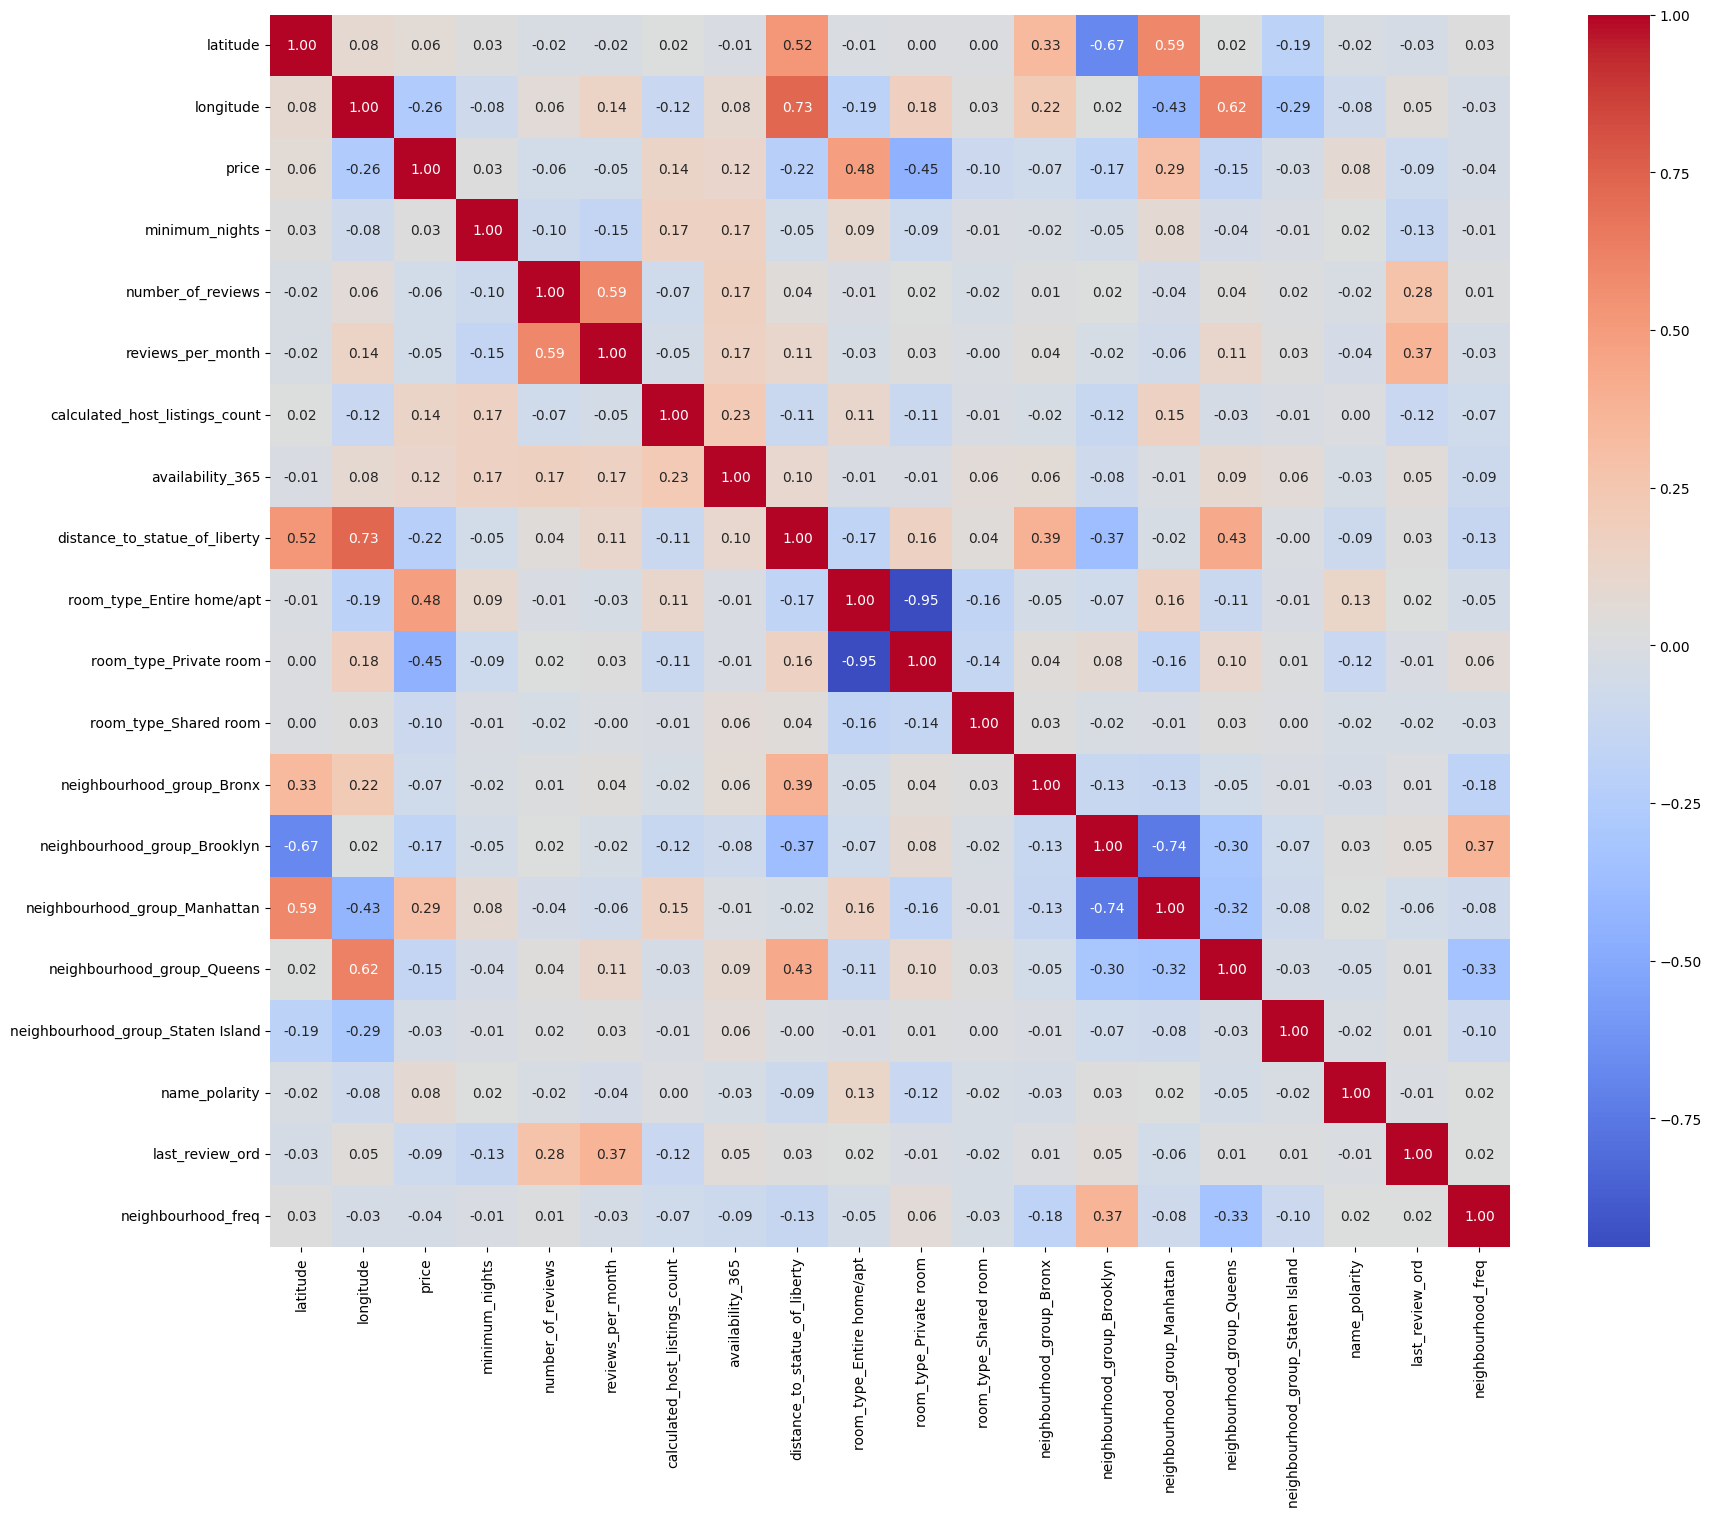

In [168]:
data_v= clean_data.copy()
for column in data_v.columns: #not going to use categorical columns for correlation analysis
    if data_v[column].dtype == 'string' or data_v[column].dtype == 'object':
        data_v.drop(column, axis=1, inplace=True)
data_corr= data_v.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(data_corr, annot=True, cmap='coolwarm', fmt='.2f')
print(data_corr['price'])

We can note that there doesn't seem to be a direct relation between any of them factors and the price, so the model must be composed by more than one factor.

#### Prediction Model

We'll now try to find a model that is able to predict, most accurately, the price of a stay in New York City.

For most of the data we plotted, we can see that there isn't a linear relation between it and the price. However, a multiple linear regression model is a good place to start. Again, we don't really expect this model to be that great, but it'll be interesting to check.

We'll start by choosing some specific features that our model will evaluate. Although we saw before that there didn't seem to be a very strong association with any of the features available, we'll choose the ones with the strongest correlation. These are 'longitude', 'distance_to_statue_of_liberty', 'room_type_Entire home/apt', 'room_type_Private room' and 'neighbourhood_group_Manhattan'.

In [169]:
sel_col= ['longitude', 'distance_to_statue_of_liberty', 'room_type_Entire home/apt', 'room_type_Private room', 'neighbourhood_group_Manhattan']
X = clean_data[sel_col]
y = clean_data['price']

#ensuring that all the features are on the same scale
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=42)

#now using the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))
print(f"Mean: {y.mean()}, Std Dev: {y.std()}")

Mean Squared Error: 8810.596120799963
R-squared: 0.3090403247610902
Mean: 140.33108679074178, Std Dev: 112.92044849867557


As we were expecting, this model performs terribly. Our predicions are very different from the actual results and our model doesn't fit the data at all (high MSE and low $R^2$). We'll move on to non-linear models.

##### Random Forest Regressor

For this model, we'll use all the available features!

In [ ]:
X = clean_data.drop(['price'],axis=1)
y = clean_data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Index(['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'distance_to_statue_of_liberty',
       'room_type_Entire home/apt', 'room_type_Private room',
       'room_type_Shared room', 'neighbourhood_group_Bronx',
       'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan',
       'neighbourhood_group_Queens', 'neighbourhood_group_Staten Island',
       'name_polarity', 'last_review_ord', 'neighbourhood_freq'],
      dtype='object')


In [ ]:
regressor_rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    oob_score=True,  
    random_state=42)


regressor_rf.fit(X_train, y_train)

y_pred = regressor_rf.predict(X_test)

print("Mean Squared Error (MAE):", mean_absolute_error(y_test, y_pred))
print("Root mean square error (RMSE) :", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))

RandomForestRegressor(max_depth=10, min_samples_split=5, n_estimators=200,
                      oob_score=True, random_state=42)

Clearly, although it isn't completely horrible, this model performs very badly, which means we made some mistakes along the way, particularly our feature engineering could not have been as strong as it should and we took into account raw features that affected our model negatively. 

We can note that RMSE is much more sensitive to outliers and so the huge difference of values between the MAE and the RMSE may be caused by outlier values that still affect the data. However, we already filtered some outliers so, in order not to eliminate any more data, we'll try different approaches. 

As we had seen, the price feature has a right-skewed distribution, which we hadn't accounted yet. We can perform the log transformation to try and normalize this data. Let's see if our model is improved:

In [176]:
regressor_rf_log = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    oob_score=True,  
    random_state=42)


y_log = np.log1p(clean_data['price'])
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)


regressor_rf_log.fit(X_train, y_train_log)
y_pred_log = regressor_rf_log.predict(X_test)


print("Mean Squared Error (MAE):", mean_absolute_error(y_test_log, y_pred_log))
print("Root mean square error (RMSE) :", mean_squared_error(y_test_log, y_pred_log))
print("R-squared:", r2_score(y_test_log, y_pred_log))


y_pred_original = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test_log)

Mean Squared Error (MAE): 0.2951678484956969
Root mean square error (RMSE) : 0.15468725978555084
R-squared: 0.6407234576958118


This model seems to work much better! We can see that not only has the $R^2$ value become closer to 1, but the MAE and RMSE have significantly been reduced! 

##### XGB Regressor

In [ ]:
xgb_model = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train) #same training data as before

y_pred = xgb_model.predict(X_test)

# Calculate the mean squared error and R-squared score
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)


print("Mean Squared Error (MAE):", mean_absolute_error(y_test, y_pred))
print("Root mean square error (RMSE) :", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))

Mean Squared Error (MAE): 46.884971618652344
Root mean square error (RMSE) : 6514.609375
R-squared: 0.4891001582145691


In [ ]:
xgb_log = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

y_log = np.log1p(clean_data['price'])
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)


xgb_log.fit(X_train, y_train_log)
y_pred_log = xgb_log.predict(X_test)


print("Mean Squared Error (MAE):", mean_absolute_error(y_test_log, y_pred_log))
print("Root mean square deviation (RMSE) :", mean_squared_error(y_test_log, y_pred_log))
print("R-squared:", r2_score(y_test_log, y_pred_log))


y_pred_original = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test_log)

Mean Squared Error (MAE): 0.28947500150894534
Root mean square deviation (RMSE) : 0.14873078756328362
R-squared: 0.6545579567186397


The xgb model ended up having a slightly better performance than the random forest one, which is the case for many situations, as this model tends to be better at handling class imbalances, with an increased accuracy. 

In [ ]:
lgbm = LGBMRegressor(
    n_estimators=1000,               
    learning_rate=0.05,              
    num_leaves=63,                   
    max_depth=-1,                    
    feature_fraction=0.8,            
    min_child_samples=20,            
    reg_alpha=0.1,                   
    reg_lambda=0.1,                  
    random_state=42,
    importance_type='gain',          
    force_col_wise=True,             
    early_stopping_round=50,         
    verbose=10                       
)


lgbm.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)]      
)

y_pred = lgbm.predict(X_test)

print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R-squared:", r2_score(y_test, y_pred))


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Total Bins 2230
[LightGBM] [Info] Number of data points in the train set: 38815, number of used features: 19
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 140.390699
[LightGBM] [Debug] Trained a tree with leaves = 63 and depth = 11
Training until validation scores don't improve for 50 rounds
[LightGBM] [Debug] Trained a tree with leaves = 63 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 63 and depth = 12
[LightGBM] [Debug] Trained 

In [200]:
lgbm_log = LGBMRegressor(
    n_estimators=1000,               
    learning_rate=0.05,              
    num_leaves=63,                   
    max_depth=-1,                    
    feature_fraction=0.8,            
    min_child_samples=20,            
    reg_alpha=0.1,                   
    reg_lambda=0.1,                  
    random_state=42,
    importance_type='gain',          
    force_col_wise=True,             
    early_stopping_round=50,         
    verbose=10                       
)

y_log = np.log1p(clean_data['price'])
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

lgbm_log.fit(
    X_train, y_train_log,
    eval_set=[(X_test, y_test_log)]      
)


y_pred_log = lgbm_log.predict(X_test)


print("Mean Squared Error (MAE):", mean_absolute_error(y_test_log, y_pred_log))
print("Root mean square deviation (RMSE) :", mean_squared_error(y_test_log, y_pred_log))
print("R-squared:", r2_score(y_test_log, y_pred_log))


y_pred_original = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test_log)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Total Bins 2230
[LightGBM] [Info] Number of data points in the train set: 38815, number of used features: 19
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 4.722479
[LightGBM] [Debug] Trained a tree with leaves = 63 and depth = 9
Training until validation scores don't improve for 50 rounds
[LightGBM] [Debug] Trained a tree with leaves = 63 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 63 and depth = 9
[LightGBM] [Debug] Trained a tr